In [1]:
import taichi as ti
from setup.voxel_setup import setup_voxel_scene
from simulation.simulator import *
from common.plot import Plotter
from common.octree import Octree

# debug=True to check boundary access
ti.init(arch=ti.gpu)

import numpy as np
import matplotlib
from scipy import ndimage

%load_ext autoreload
%autoreload 2

# matplotlib.use('Qt5Agg')
%matplotlib widget

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] Starting on arch=cuda


## 1. Load voxel model

In [2]:
NUM_X, NUM_Y, NUM_Z = 128, 128, 128
scene, floor_height = setup_voxel_scene(NUM_X, NUM_Y, NUM_Z)

Loaded Voxel shape: (128, 128, 128)  from: ./assets/bun_zipper_res4.ply
Number of filled voxels: 13849
Loaded Voxel shape: (128, 128, 128)  from: ./assets/wine_glass.obj
Number of filled voxels: 9035
Floor Ratio: -0.3125 , Floor Height: 44


In [3]:
# scene.finish()

## 2. Light simulation

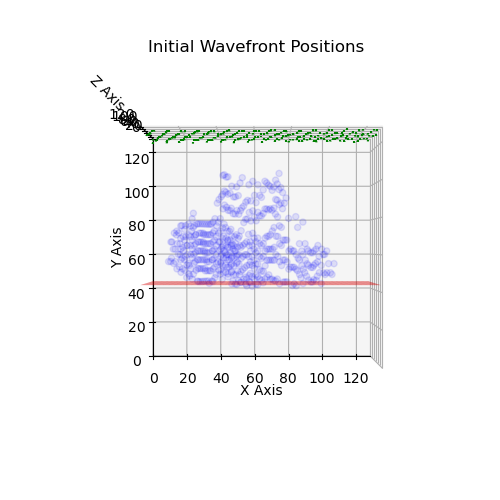

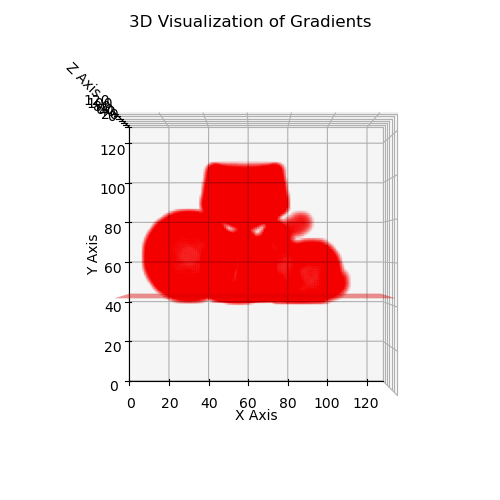

In [4]:
assert scene.ior.shape == (NUM_X, NUM_Y, NUM_Z), "The scene IOR should be a NumPy array of shape (NUM_X, NUM_Y, NUM_Z)"

sampler_multiplier = 3
pos_perturbation_scale = 0.45
initial_wavefront_pos, initial_wavefront_dir = generate_initial_wavefront(sampler_multiplier, pos_perturbation_scale, NUM_X, NUM_Y, NUM_Z)

scene.ior = ndimage.gaussian_filter(scene.ior, sigma=3.0, radius=1)
scene.gradient = compute_ior_gradient(scene.ior)

plotter = Plotter(sampler_multiplier, floor_height, scene.ior)
plotter.plot_wavefront_position(initial_wavefront_pos, initial_wavefront_dir, title="Initial Wavefront Positions")
plotter.plot_gradient(scene.gradient, threshold=0.01, alpha=0.01)

In [5]:
test_delta_t = 0.3 * (NUM_Y / 100)
test_num_steps = int(1.1 * (NUM_Y / test_delta_t))
raw_irradiance, scene.local_diretion = simulate_wavefront_propagation(scene.ior, scene.gradient, scene.attenuation,
                                                initial_wavefront_pos, initial_wavefront_dir,
                                                plotter, test_num_steps, step_size=test_delta_t, num_show_images=0)

# plotter.plot_local_direction_grid_slices(scene.local_diretion, num_slices=8, z_start=30, z_end=120, stream_plot=False)
raw_irradiance = remove_under_floor(raw_irradiance, floor_height=floor_height)
scene.irradiance = ndimage.gaussian_filter(raw_irradiance, sigma=0.8) 

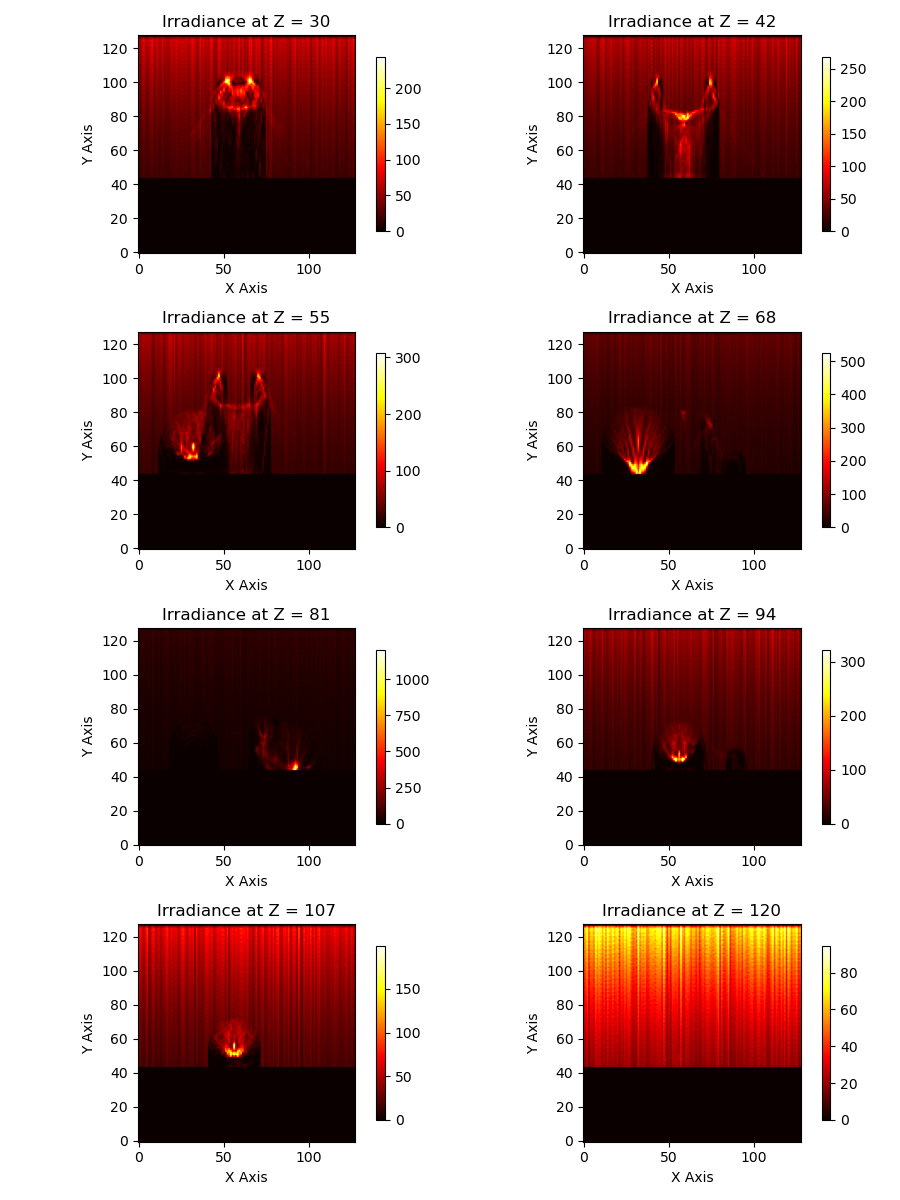

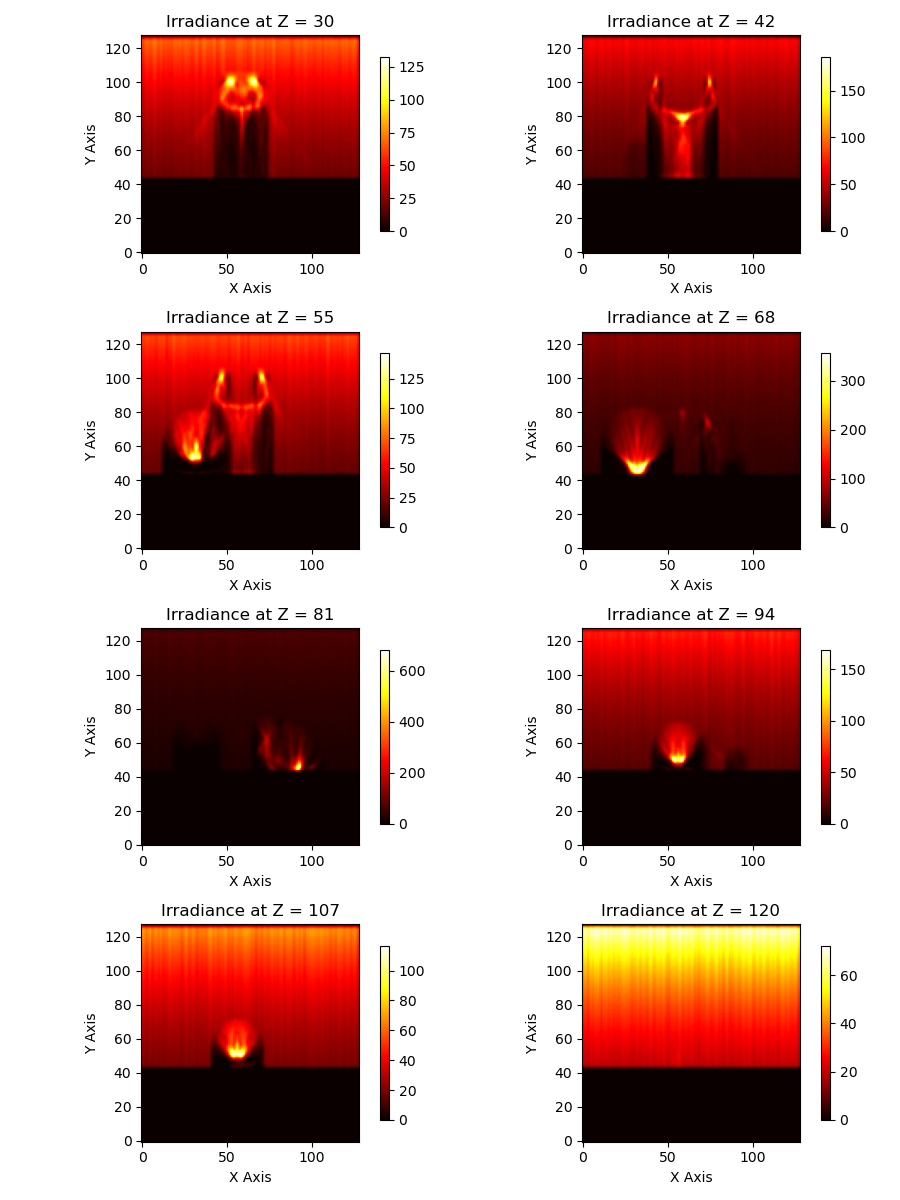

In [6]:
plotter.plot_irradiance_slices(raw_irradiance, threshold=3, num_slices=8, z_start=30, z_end=120)
plotter.plot_irradiance_slices(scene.irradiance, threshold=3, num_slices=8, z_start=30, z_end=120)

## 3. Visualise irradiance

In [7]:
# plotter.plot_irradiance_grid(irradiance_grid, threshold=5*sampler_multiplier**3)


In [8]:
# Apply Gaussian filter to smooth the radiometric grid


## 6. Neural network irradiance （MLP）

In [16]:
import torch.nn as nn

class IrradianceNet(nn.Module):
    def __init__(self):
        super(IrradianceNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                
    def forward(self, x):
        return self.model(x).squeeze()

def prepare_data(irradiance: np.ndarray, val_ratio=0.1) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    irradiance_tensor = torch.tensor(irradiance[:, floor_height:, :], dtype=torch.float32)
    x = np.arange(irradiance_tensor.shape[0])
    z = np.arange(irradiance_tensor.shape[2])
    X, Z = np.meshgrid(x, z)    
    inputs = []
    targets = []
    for y in range(irradiance_tensor.shape[1]):
        coords = np.stack((X, np.full_like(X, y), Z), axis=-1).reshape(-1, 3)
        inputs.append(coords)
        targets.append(irradiance_tensor[:, y, :].flatten())
    
    inputs = np.concatenate(inputs)
    targets = torch.cat(targets)

    print("Inputs shape:", inputs.shape, "; Targets shape:", targets.shape)
    inputs = torch.from_numpy(inputs).float().to(DEVICE)
    targets = targets.clone().detach().to(DEVICE)

    # Random shuffle
    SEED = 42 # For reproducibility
    torch.manual_seed(SEED)
    indices = torch.randperm(len(inputs))
    inputs = inputs[indices]
    targets = targets[indices]

    # train_inputs use all inputs because we use all data for training to get overfitting
    train_size = int((1- val_ratio) * len(inputs))
    train_inputs, val_inputs = inputs[:], inputs[train_size:] 
    train_targets, val_targets = targets[:], targets[train_size:]

    return train_inputs, val_inputs, train_targets, val_targets

def train_model(model: IrradianceNet, train_inputs: torch.Tensor, val_inputs: torch.Tensor, 
                train_targets: torch.Tensor, val_targets: torch.Tensor, 
                num_epochs=100, batch_size=1024):
    torch.cuda.empty_cache()
    print("Device:", DEVICE)
    
    prev_lr = 0.001

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=prev_lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(train_inputs), batch_size):
            batch_inputs = train_inputs[i:i+batch_size]
            batch_targets = train_targets[i:i+batch_size]
            
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            scheduler.step(val_loss)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

            if scheduler.get_last_lr()[0] != prev_lr:
                prev_lr = scheduler.get_last_lr()[0]
                print("Current learning rate:", prev_lr)

    torch.cuda.empty_cache()
    return model

train_inputs, val_inputs, train_targets, val_targets = prepare_data(scene.irradiance)
model = IrradianceNet().to(DEVICE)  
model = train_model(model, train_inputs, val_inputs, train_targets, val_targets, num_epochs=20)

Inputs shape: (1376256, 3) ; Targets shape: torch.Size([1376256])
Device: cuda
Epoch [5/20], Train Loss: 92.3987, Val Loss: 150.7531
Epoch [10/20], Train Loss: 60.1385, Val Loss: 93.0860
Epoch [15/20], Train Loss: 51.1206, Val Loss: 84.3839
Epoch [20/20], Train Loss: 34.6461, Val Loss: 67.3837


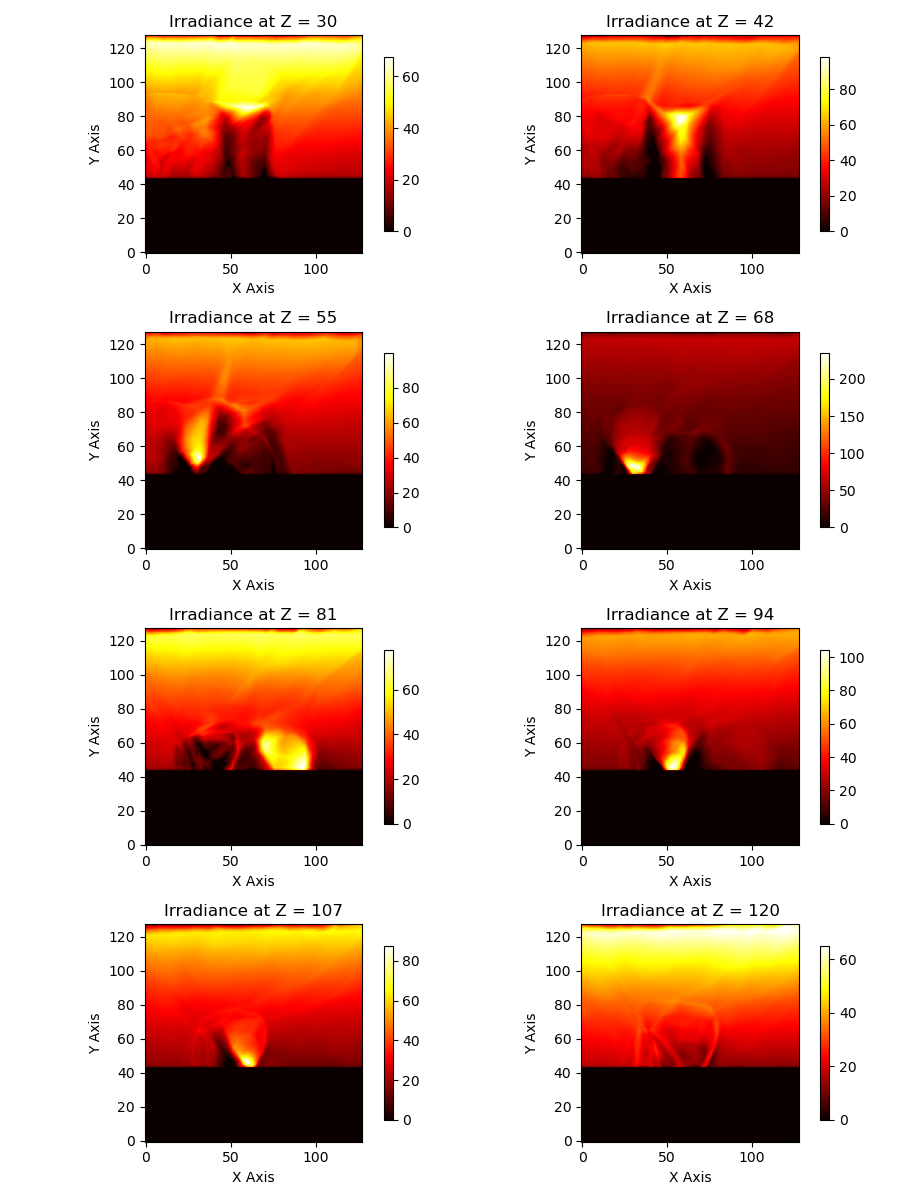

In [24]:
def generate_irradiance_field_3d(model: IrradianceNet, pad: bool=False, batch_size: int = 2048) -> torch.Tensor:
    x = np.arange(NUM_X)
    z = np.arange(NUM_Z)
    X, Z = np.meshgrid(x, z)
    
    predictions = []
    with torch.no_grad():
        for y in range(NUM_Y - floor_height):
            coords = np.stack((X, np.full_like(X, y), Z), axis=-1).reshape(-1, 3)
            
            y_predictions = []
            for i in range(0, len(coords), batch_size):
                batch_coords = coords[i:i+batch_size]
                inputs = torch.tensor(batch_coords, dtype=torch.float32, device=DEVICE)
                batch_predictions = model(inputs)
                y_predictions.append(batch_predictions)
            
            y_predictions = torch.cat(y_predictions)
            y_predictions = y_predictions.reshape(NUM_X, NUM_Z)
            predictions.append(y_predictions)
    
    predictions = torch.stack(predictions)
    predictions = predictions.transpose(0, 1)
    
    # 填充低于floor_height的区域
    if pad:
        padding = (0, 0, floor_height, 0, 0, 0) 
        predictions = torch.nn.functional.pad(predictions, padding, mode='constant', value=0)
    
    return predictions


# Visualize the predicted irradiance field
predicted_irradiance = generate_irradiance_field_3d(model, pad=True)
plotter.plot_irradiance_slices(predicted_irradiance.cpu().numpy(), threshold=3, num_slices=8, z_start=30, z_end=120)

## 7. Octree

Number of nodes: 117145
Octree Memory usage: 6560120 bytes
In comparison, NumPy Storage Usage: 8388608 bytes


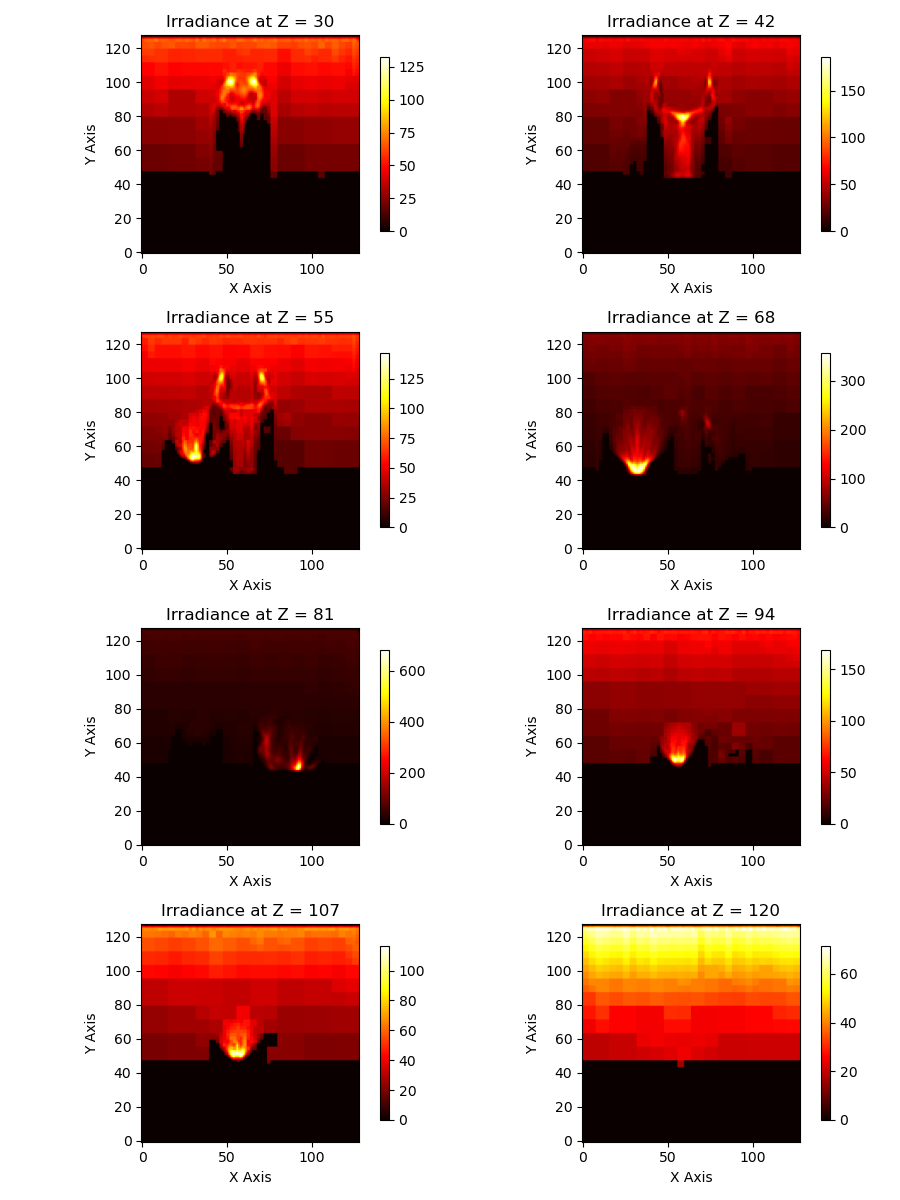

In [11]:
octree = Octree(threshold=int(0.6 * (sampler_multiplier**3)))
octree.construct(scene.irradiance)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {scene.irradiance.nbytes} bytes")
octree.visualize(plotter)

In [12]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

4.998753

## Temp Tests

In [13]:
@ti.data_oriented
class TiArray:
    def __init__(self, n):
        self.x = ti.field(dtype=ti.i32, shape=n)

    @ti.kernel
    def inc(self):
          
        for i in self.x:
            self.x[i] += 1

a = TiArray(32)
a.inc()
print(a.x.to_numpy())
print(a.x.dtype)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
i32


## *. Render